<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Task-Manager-agent" data-toc-modified-id="Task-Manager-agent-1">Task Manager agent</a></span><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1.1">Goal</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-1.2">Imports</a></span></li><li><span><a href="#Matching-the-viral-baseline" data-toc-modified-id="Matching-the-viral-baseline-1.3">Matching the viral baseline</a></span><ul class="toc-item"><li><span><a href="#Visualization" data-toc-modified-id="Visualization-1.3.1">Visualization</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.3.2">Evaluation</a></span></li></ul></li><li><span><a href="#Play-against-working-title-bot" data-toc-modified-id="Play-against-working-title-bot-1.4">Play against working title bot</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.5">Summary</a></span><ul class="toc-item"><li><span><a href="#Learnings" data-toc-modified-id="Learnings-1.5.1">Learnings</a></span></li></ul></li><li><span><a href="#TODO" data-toc-modified-id="TODO-1.6">TODO</a></span></li></ul></li></ul></div>

# Task Manager agent

## Goal

The goal is to implement a task manager bot. At the start of the turn the bot will assign different tasks to the units and later it will coordinate the actions based on their priority.

As a start point I will simply try to get a similar bot to `viral` and once I have that foundation I will start improving it.

## Imports

In [1]:
# Use this to reload changes in python scripts
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from kaggle_environments import make, evaluate
from functools import partial
from IPython.display import clear_output
from tqdm.notebook import tqdm

from luxai.utils import render_game_in_html, create_temporal_python_file, set_random_seed
from luxai.agents.task_manager import TaskManagerAgent
from luxai.evaluation import play_matches_in_parallel, compute_result_ratios

Loading environment football failed: No module named 'gfootball'


In [3]:
plt.plot()
plt.close('all')
plt.rcParams["figure.figsize"] = (20, 5)  
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 16

## Matching the viral baseline

### Visualization

In [4]:
env = make("lux_ai_2021", debug=True, 
           configuration={'width': 12, 'height': 12, 'seed': 1, 
                          'episodeSteps': 41, 'annotations':True})
game_info = env.run(['simple_agent', TaskManagerAgent(1)])

In [3]:
set_random_seed(7)
env = make("lux_ai_2021", debug=True, 
           configuration={'width': 12, 'height': 12, 'seed': 0, 
                          'episodeSteps': 361, 'annotations':True})
game_info = env.run(['simple_agent', TaskManagerAgent(0.8)])
render_game_in_html(env)

Opening in existing browser session.


In [6]:
env = make("lux_ai_2021", debug=True, 
           configuration={'width': 12, 'height': 12, 'seed': 2, 
                          'episodeSteps': 361, 'annotations':True})
game_info = env.run(['../agents/viral.py', TaskManagerAgent(0)])
render_game_in_html(env)

Opening in existing browser session.


In [6]:
env = make("lux_ai_2021", debug=True, 
           configuration={'width': 12, 'height': 12, 'seed': 2, 
                          'episodeSteps': 361, 'annotations':True})
game_info = env.run(['../agents/viral.py', '../agents/dwight.py'])
render_game_in_html(env)

Opening in existing browser session.


In [5]:
raise

RuntimeError: No active exception to reraise

### Evaluation

Create a temporal file with the agent and play against simple and viral agent.

In [4]:
def evaluate_against_viral_agent(temporal_agent, n_matches=200):
    matches_results = play_matches_in_parallel(agents=[temporal_agent, '../agents/viral.py'], n_matches=n_matches)
    matches_results += [result[::-1] for result in play_matches_in_parallel(agents=['../agents/viral.py', temporal_agent], n_matches=n_matches)]
    return compute_result_ratios(matches_results)

In [9]:
text = """
from luxai.agents.task_manager import TaskManagerAgent

global_agent = TaskManagerAgent(0.9)

def agent(observation, configuration):
    return global_agent(observation, configuration)
"""
temporal_agent = create_temporal_python_file(text)

In [11]:
evaluate_against_viral_agent(temporal_agent)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

(0.5675, 0.025, 0.4075)

In [5]:
matches_results = play_matches_in_parallel(agents=[temporal_agent, 'simple_agent'])
compute_result_ratios(matches_results)

  0%|          | 0/100 [00:00<?, ?it/s]

(0.01, 0.99, 0.0)

Text(0, 0.5, 'win rate')

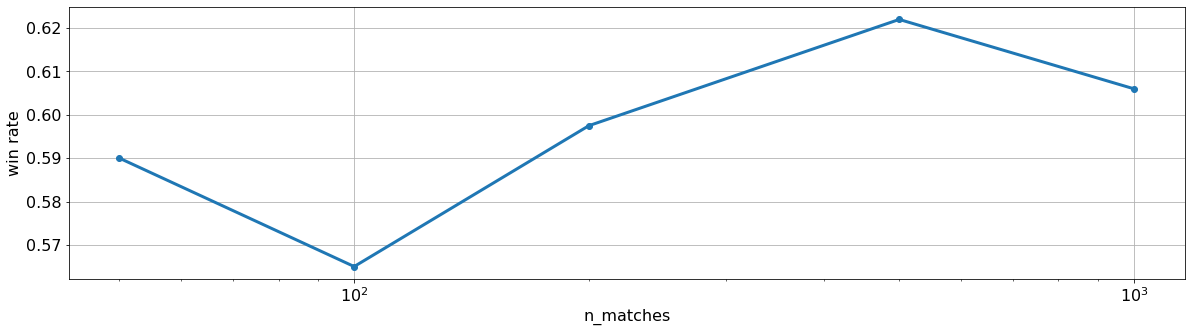

In [19]:
n_matches = [50, 100, 200, 500, 1000]
win_rate = [0.59, 0.565, 0.5975, 0.622, 0.606]
plt.plot(n_matches, win_rate, marker='o')
plt.grid()
plt.xscale('log')
plt.xlabel('n_matches')
plt.ylabel('win rate')

In [15]:
evaluate_against_viral_agent(temporal_agent, n_matches=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(0.606, 0.0175, 0.3765)

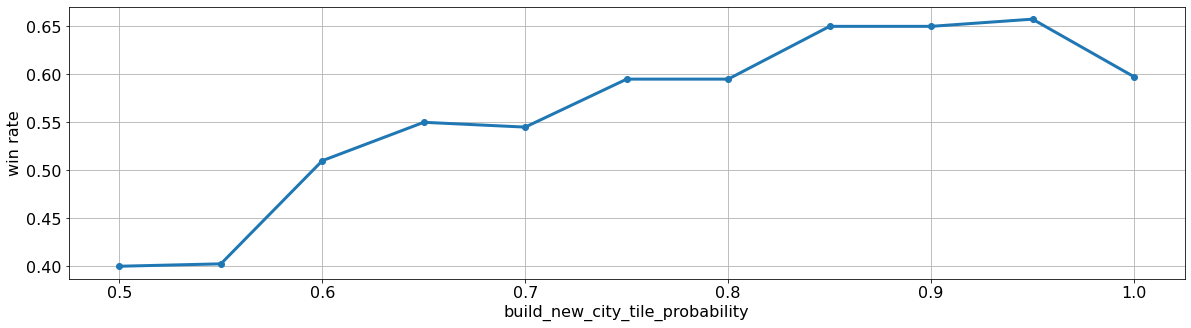

In [8]:
alpha_range = np.linspace(0.5, 1, 11)
n_matches = 200
results = []
for alpha in tqdm(alpha_range, desc=''):
    text = """
from luxai.agents.task_manager import TaskManagerAgent

global_agent = TaskManagerAgent(%.2f)

def agent(observation, configuration):
    return global_agent(observation, configuration)
"""
    temporal_agent = create_temporal_python_file(text % alpha)
    results.append(evaluate_against_viral_agent(temporal_agent, n_matches=n_matches))
    clear_output()
    plt.plot(alpha_range[:len(results)], [result[0] for result in results], marker='o')
    plt.ylabel('win rate')
    plt.xlabel('build_new_city_tile_probability')
    plt.grid()
    plt.show()

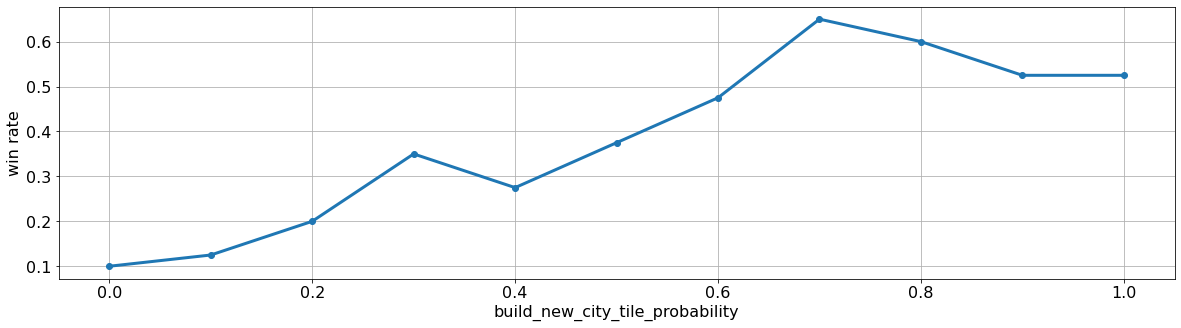

In [8]:
plt.plot(alpha_range[:len(results)], [result[0] for result in results], marker='o')
plt.ylabel('win rate')
plt.xlabel('build_new_city_tile_probability')
plt.grid()
plt.show()

## Play against working title bot

https://www.kaggle.com/huikang/lux-ai-working-title-bot/output?select=submission.tar.gz

In [5]:
forum_agent = '../agents/working_title/agent.py'

In [ ]:
set_random_seed(7)
env = make("lux_ai_2021", debug=True, 
           configuration={'width': 12, 'height': 12, 'seed': 0, 
                          'episodeSteps': 361, 'annotations':True})
game_info = env.run([forum_agent, TaskManagerAgent(0.8)])
render_game_in_html(env)

In [6]:
n_matches = 200

matches_results = play_matches_in_parallel(agents=[forum_agent, '../agents/viral.py'], n_matches=n_matches)
matches_results += [result[::-1] for result in play_matches_in_parallel(agents=['../agents/viral.py', forum_agent], n_matches=n_matches)]
compute_result_ratios(matches_results)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

(0.9525, 0.0, 0.0475)

In [6]:
n_matches = 200

matches_results = play_matches_in_parallel(agents=[forum_agent, '../agents/dwight.py'], n_matches=n_matches)
matches_results += [result[::-1] for result in play_matches_in_parallel(agents=['../agents/dwight.py', forum_agent], n_matches=n_matches)]
compute_result_ratios(matches_results)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

(0.9325, 0.0025, 0.065)

## Summary

### Learnings

## TODO

Function to create a temporal file with the agent